In [2]:
import pandas as pd

In [3]:
data = pd.read_csv('data_creation.csv')

In [4]:
data[data['Season'] == 2024].head()

,Season,Round,TeamA,TeamB,SeedTeamA,SeedTeamB,ScoreTeamA,ScoreTeamB,TeamA_TotScore,TeamA_TotFGM,...,TeamB_AvgTotOppFTM,TeamB_AvgTotOppFTA,TeamB_AvgTotOppOR,TeamB_AvgTotOppDR,TeamB_AvgTotOppAst,TeamB_AvgTotOppTO,TeamB_AvgTotOppStl,TeamB_AvgTotOppBlk,TeamB_AvgTotOppPF,ResultTeamA
1315,2024,0.0,Colorado,Boise St,10,10,60,53,2696,963,...,13.1,18.2,6.4,21.7,11.5,10.6,5.7,3.9,17.3,1
1316,2024,0.0,Colorado St,Virginia,10,10,67,42,2404,867,...,10.3,13.7,7.9,23.9,11.2,11.2,5.1,3.2,13.0,1
1317,2024,0.0,Wagner,Howard,16,16,71,68,1789,638,...,16.0,22.8,9.1,19.9,12.3,11.3,7.6,3.7,19.0,1
1318,2024,0.0,Grambling,Montana St,16,16,88,81,2019,700,...,15.0,21.0,8.2,24.4,12.4,12.6,5.8,2.6,17.4,1
1319,2024,1.0,Purdue,Grambling,1,16,78,50,2752,941,...,14.0,19.0,9.4,21.5,13.4,12.0,7.3,2.9,16.3,1


In [5]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
import sys

data = pd.read_csv('data_creation.csv')

# Load and preprocess data
data = data[data['Season'] != 2021].drop(columns=['ScoreTeamA', 'ScoreTeamB'])

train = data[data['Season'] < 2024].drop(columns=['Season'])
train_teams = train[['TeamA', 'TeamB']]
train_X = train.drop(columns=['TeamA', 'TeamB', 'ResultTeamA'])
train_Y = train['ResultTeamA']
test = data[data['Season'] == 2024].drop(columns=['Season'])

test_teams = test[['TeamA', 'TeamB']]
test_X = test.drop(columns=['TeamA', 'TeamB', 'ResultTeamA'])
test_Y = test['ResultTeamA']

model = LogisticRegression(max_iter=10000)
model.fit(train_X, train_Y)

# Full bracket simulating function
def simulate_tournament(test_data, model):
    
    # These are the colnames that aren't prefixed by TeamA/TeamB but still may be
    # relevant predictors so I explicitly say them here
    # MAYBE THIS IS WHERE WE CAN ADD IN THEIR FEATURE ENGINEERED STUFF AS A FUNC ARG
    extra_cols_a = ['TotG', 'TotW', 'TotL', 'NeutralG', 'WinPct']
    extra_cols_b = ['TotG.1', 'TotW.1', 'TotL.1', 'NeutralG.1', 'WinPct.1']
    
    # Filter data to just R1
    # THIS IS USELESS IN THE FUTURE JUST DOING BC WE ARE TESTING ON DATA w/ FULL ROUND INFO!
    test_data = test_data[test_data['Round'] == 1]
    
    # Define R1 matchups
    init_a = test_data['TeamA'].tolist()
    init_b = test_data['TeamB'].tolist()
    
    inits = []
    
    for i in range(32):
        inits.append(init_a[i])
        inits.append(init_b[i])
    
    # Make our list of round by round preds to spit out
    to_return = []
    
    # Start with R1 (0 is first 4 which we dc about)
    current_round = 1
    
    # Run until we do the finals
    while current_round <= 6:
        # Filter to just current round
        round_data = test_data[test_data['Round'] == current_round]
        
        # If somehow no data, end
        if round_data.empty:
            break

        # Get our predictors and the teams by row
        round_X = round_data.drop(columns=['TeamA', 'TeamB', 'ResultTeamA'])
        round_teams = round_data[['TeamA', 'TeamB']]
        

        # Predict winners using the model you made
        predictions = model.predict(round_X)
        
        # Get the winner names
        winners = [row.TeamA if pred == 1 else row.TeamB for row, pred in zip(round_teams.itertuples(), predictions)]
            
        # Create new matchups for the next round
        next_round_data = []
        for i in range(0, len(winners), 2):
            if i + 1 < len(winners):
                next_team_A = winners[i]
                next_team_B = winners[i + 1]

                # Get stats for each team
                team_A_stats = test_data[(test_data['TeamA'] == next_team_A) | (test_data['TeamB'] == next_team_A)].drop(columns=['TeamA', 'TeamB', 'ResultTeamA']).iloc[-1]
                team_B_stats = test_data[(test_data['TeamA'] == next_team_B) | (test_data['TeamB'] == next_team_B)].drop(columns=['TeamA', 'TeamB', 'ResultTeamA']).iloc[-1]

            
                # Get only relevant columns
                # WE MAY NEED TO CHANGE THIS BASED ON FEATURE SELECTION/ENGINEERING
                team_A_stats = team_A_stats[team_A_stats.index.str.contains('TeamA') | team_A_stats.index.isin(extra_cols_a)]
                team_B_stats = team_B_stats[team_B_stats.index.str.contains('TeamB') | team_B_stats.index.isin(extra_cols_b)]
                
                matchup = pd.concat([pd.Series({'TeamA': next_team_A, 'TeamB': next_team_B, 'Round': current_round + 1 }), team_A_stats, team_B_stats], axis=0)
                next_round_data.append(matchup)

                    
        # Convert the next round data to DF and append to our running new data
        test_data = pd.concat([test_data, pd.DataFrame(next_round_data)], ignore_index=True)
        
        # Add our rounds winners to our return var
        to_return.append(winners)
        
        # Move to next round
        current_round += 1

    # Add the teams from R1 (predefined by seeding) and return
    # WE SHOULD ADD SEEDING TO WHAT WE RETURN FOR PLOTTING PURPOSES LATER
    return [inits] + to_return

preds = simulate_tournament(test, model)

/Users/jakesanghavi/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [6]:
# Make pairwise matchups for plotting
plot_feeder = [[tuple(sublist[j:j+2]) if j+1 < len(sublist) else (sublist[j],) 
           for j in range(0, len(sublist), 2)] for sublist in preds]

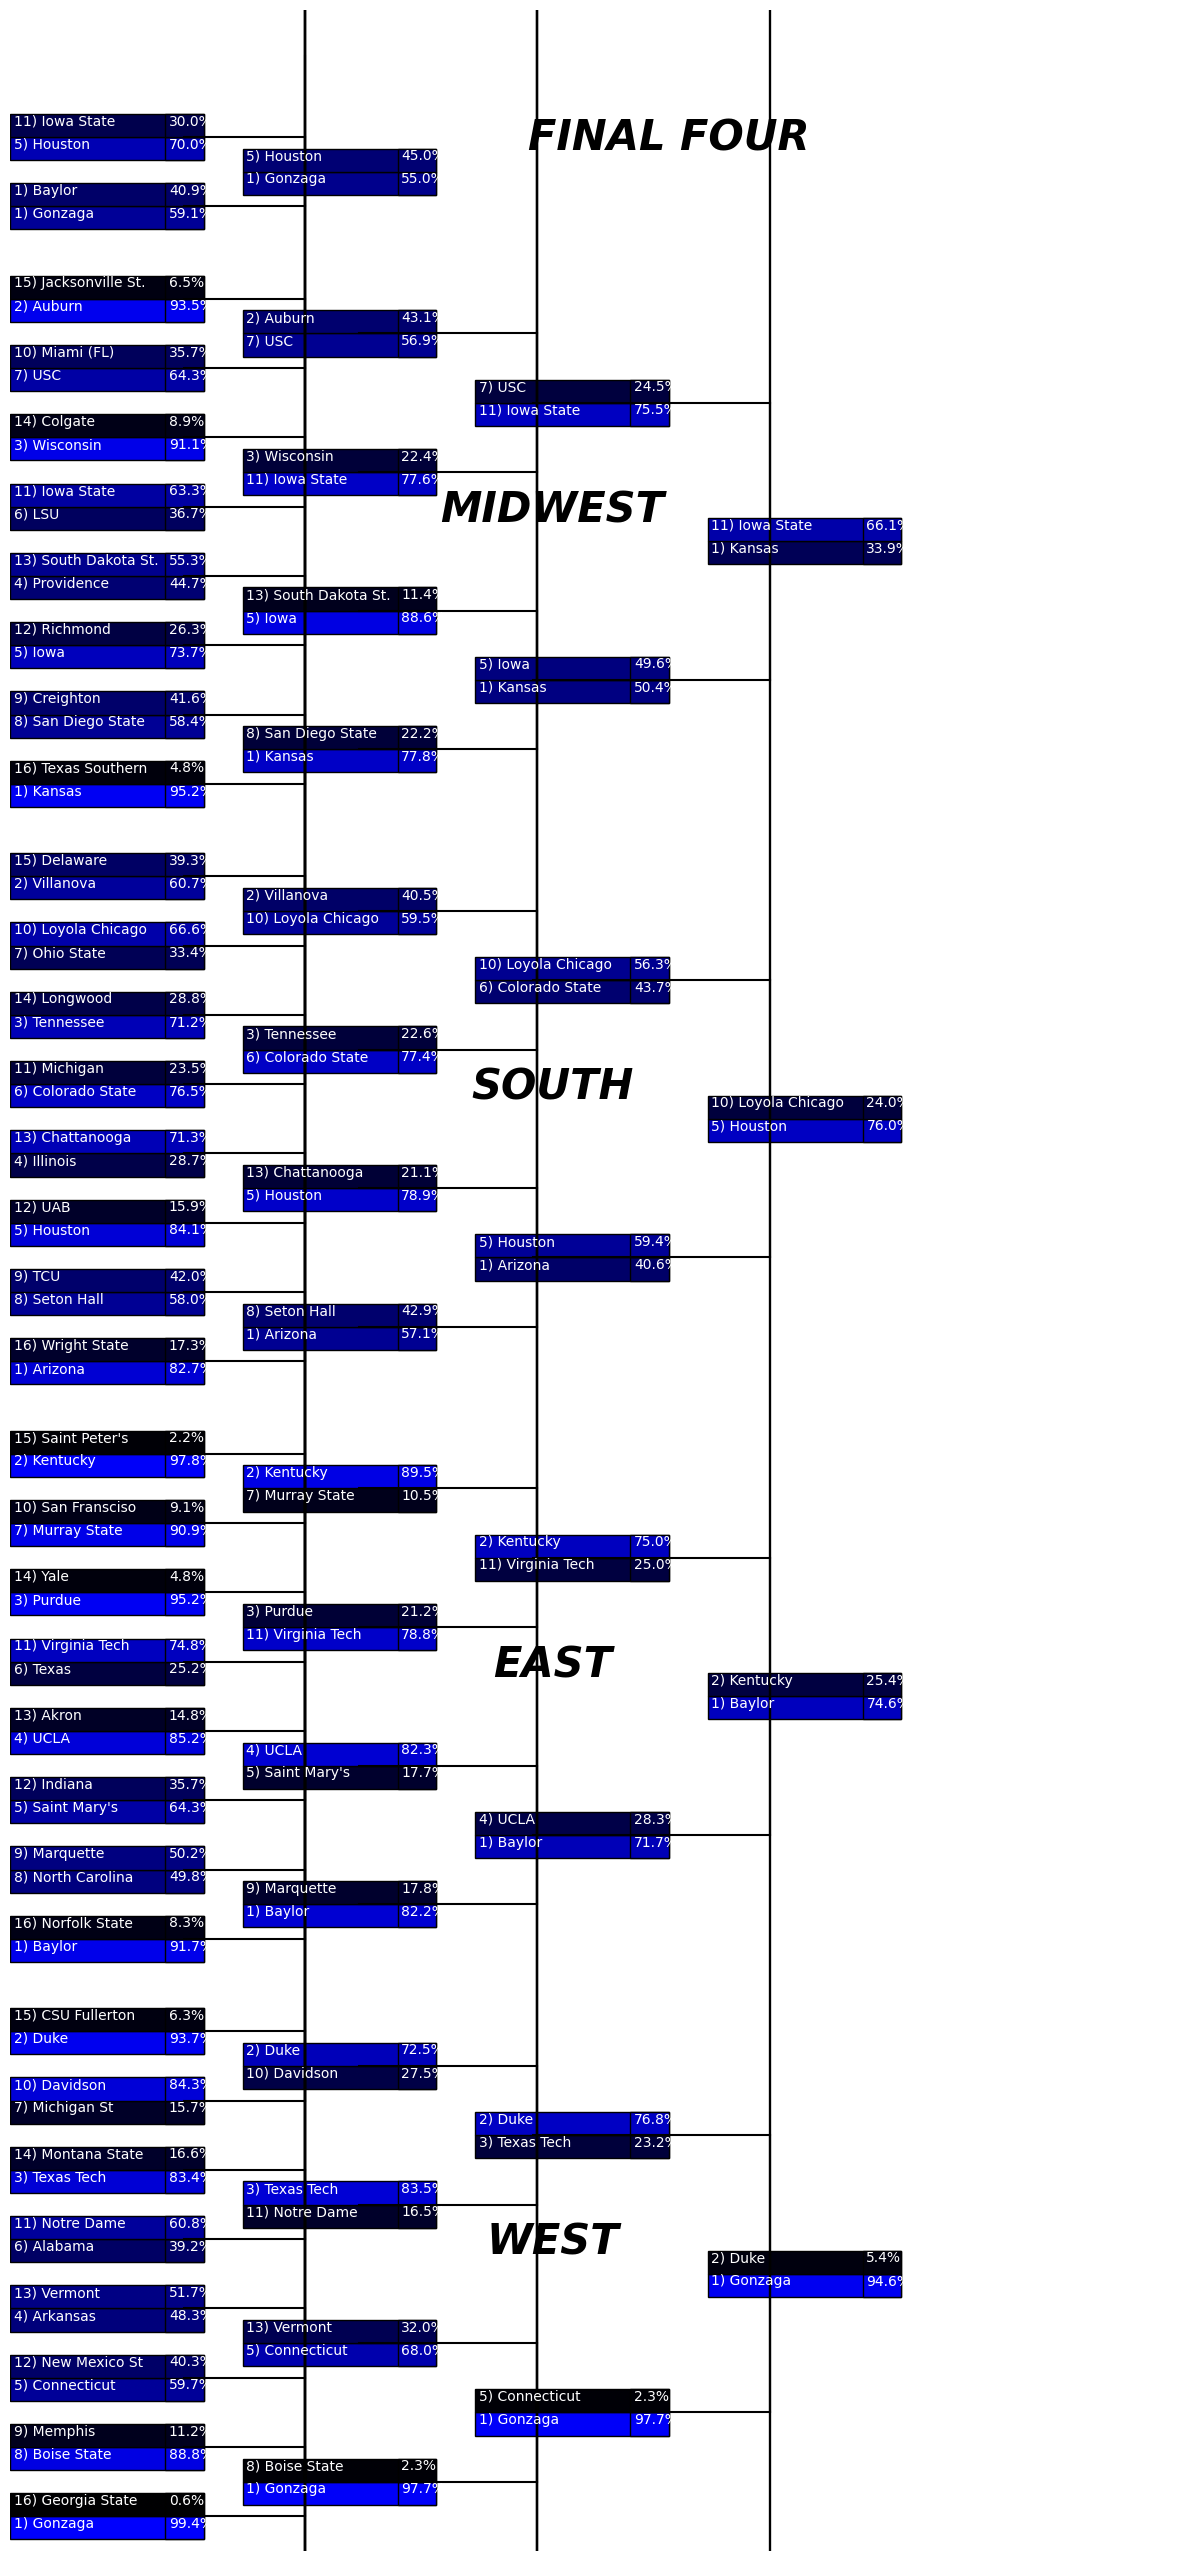

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load the dataset
df = pd.read_csv("MarchMadness2022.csv")

df["seed"] = df["seed"].astype(int)
df["position"] = df["newPos"].astype(float) * 30
df["round"] = df["round"].astype(float) * 150
df["favorite"] = df["favorite"].astype(int)
df["winPct"] = df["winPct"].astype(float) * 100

# Create figure
fig, ax = plt.subplots(figsize=(15, 33))
ax.set_xlim(0, 1500)
ax.set_ylim(0, 3300)
ax.axis("off")

def get_color(win_pct):
    """ Returns a color based on win percentage """
    return (0, 0, win_pct / 100)  # Blue gradient

# Draw team name boxes and text
for _, row in df.iterrows():
    x = (row["round"] - 150) * 2
    y = row["position"] - 15
    rect = patches.Rectangle((x, y), 250, 30, linewidth=1, edgecolor='black', facecolor=get_color(row["winPct"]))
    ax.add_patch(rect)
    ax.text(x + 5, y + 20, f"{row['seed']}) {row['team']}", color='white', fontsize=10, va='center')
    
    # Win probability box
    x_prob = (row["round"] - 50) * 2
    rect_prob = patches.Rectangle((x_prob, y), 50, 30, linewidth=1, edgecolor='black', facecolor=get_color(row["winPct"]))
    ax.add_patch(rect_prob)
    ax.text(x_prob + 5, y + 20, f"{row['winPct']:.1f}%", color='white', fontsize=10, va='center')
    
    # Horizontal bracket lines
    if row["favorite"] < 1:
        ax.plot([row["round"] + row["round"] / 2, 2 * row["round"] + 80],
                [row["position"] - 15, row["position"] - 15], color='black')
    
    # Vertical bracket lines
    if row["direction"] == "up":
        y_end = row["position"] - 30 - ((row["round"]**2)) / 10
    elif row["direction"] == "down":
        y_end = row["position"] + ((row["round"]**2) ) / 10
    else:
        y_end = row["position"] - 15
    ax.plot([2 * row["round"] + 80, 2 * row["round"] + 80], [row["position"] - 15, y_end], color='black')

# Add region labels
regions = [
    {"region": "WEST", "x": 700, "position": 12.5*30+10},
    {"region": "EAST", "x": 700, "position": 37.5*30+10},
    {"region": "SOUTH", "x": 700, "position": 62.5*30+10},
    {"region": "MIDWEST", "x": 700, "position": 87.5*30+10},
    {"region": "FINAL FOUR", "x": 850, "position": 103.5*30+12}
]
for region in regions:
    ax.text(region["x"], region["position"], region["region"], fontsize=30, fontweight='bold', ha='center', style='italic')

plt.show()

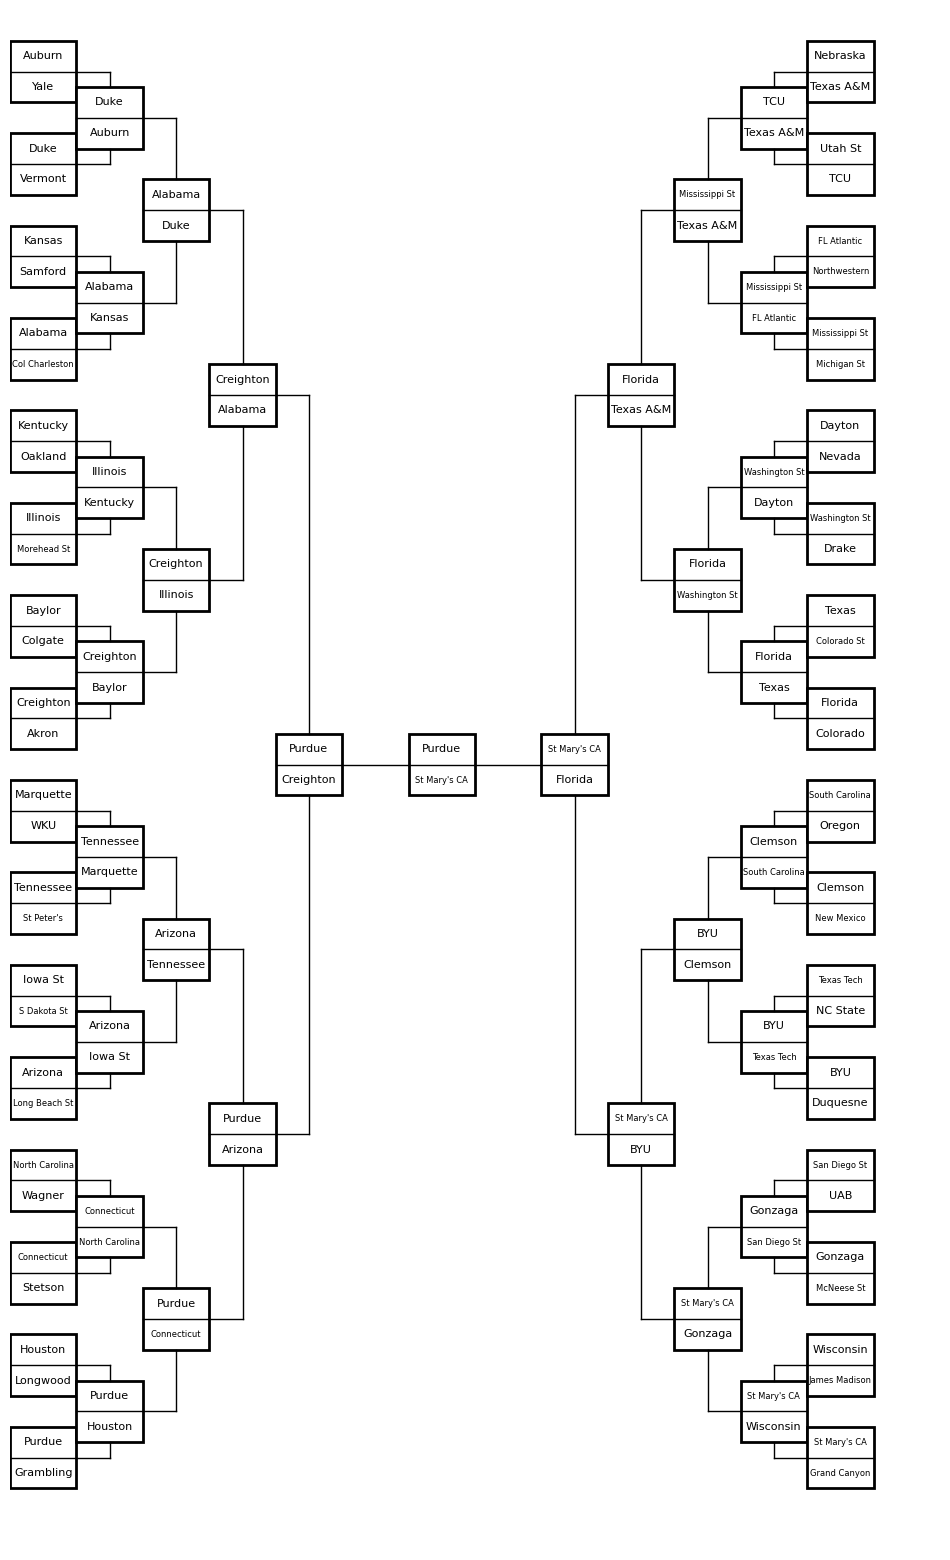

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import string

# Define base recentangle params
rect_width = 5
rect_height = 1

# Generate random letters for each rectangle
# TESTING ONLY
letters = np.random.choice(list(string.ascii_uppercase), (16, 2, 2))

fig, ax = plt.subplots(figsize=(12, 20))

# Gap sizes for each rounds
gaps = {16: 0.5, 8: 2, 4: 5, 2: 11, 1: 16}

# Extra base height for each round
y_off_add = {16: 0, 8: 0.75, 4: 2.25, 2: 5.25, 1: 11.25}

# Draw individual rectangle column (side of the bracket per round)
def draw_column(x_offset, preds, num_rectangles):
    for i in range(num_rectangles):
        gap = gaps[num_rectangles]
        y_offset = i * (rect_height + gap) + y_off_add[num_rectangles]
        
        # Add the rectangle to the plot to store matchup data
        rect = plt.Rectangle((x_offset, y_offset), rect_width, rect_height, edgecolor='black', facecolor='white', linewidth=2)
        ax.add_patch(rect)
       
        # Left columns
        if x_offset < 0:
            # As long as not semis or later, draw connecting line to next round
            if num_rectangles > 1:
                ax.plot([x_offset, x_offset + 3*rect_width/2], [y_offset + rect_height / 2] * 2, color='black', linewidth=1)
            else:
                ax.plot([x_offset, x_offset + 2*rect_width], [y_offset + rect_height / 2] * 2, color='black', linewidth=1)
                
            # Direction of connecting "elbow" depends on if matchup is below or above middle line
            if i % 2 == 1 and num_rectangles > 1:
                ax.plot([x_offset + 3*rect_width/2] * 2, [y_offset + rect_height / 2, y_offset - gap/2 + rect_height/2], color='black', linewidth=1)
            elif i % 2 == 0 and num_rectangles > 1:
                ax.plot([x_offset + 3*rect_width/2] * 2, [y_offset + rect_height / 2, y_offset + gap/2 + rect_height/2], color='black', linewidth=1)
        
        # Right columns
        elif x_offset > 0:
            # As long as not semis or later, draw connecting line to next round
            if num_rectangles > 1:
                ax.plot([x_offset - rect_width/2, x_offset + rect_width], [y_offset + rect_height / 2] * 2, color='black', linewidth=1)
            else:
                ax.plot([x_offset - rect_width, x_offset + rect_width], [y_offset + rect_height / 2] * 2, color='black', linewidth=1)
            
            # Direction of connecting "elbow" depends on if matchup is below or above middle line
            if i % 2 == 1 and num_rectangles > 1:
                ax.plot([x_offset - rect_width/2] * 2, [y_offset + rect_height / 2, y_offset - gap/2 + rect_height/2], color='black', linewidth=1)
            elif i % 2 == 0 and num_rectangles > 1:
                ax.plot([x_offset - rect_width/2] * 2, [y_offset + rect_height / 2, y_offset + gap/2 + rect_height/2], color='black', linewidth=1)
        
        # Center (finals)
        else:
            ax.plot([x_offset, x_offset + rect_width], [y_offset + rect_height / 2] * 2, color='black', linewidth=1)
        
        # Add team names (as long as > 1 team left)
        if len(preds) > 0 and len(preds[i]) > 1:
            ax.text(x_offset + rect_width / 2, y_offset + (3/4) * rect_height, \
                    preds[i][0], fontsize=8 if len(preds[i][0]) < 10 else 6, ha='center', va='center')
            ax.text(x_offset + rect_width / 2, y_offset + (1/4) * rect_height, \
                    preds[i][1], fontsize=8 if len(preds[i][1]) < 10 else 6, ha='center', va='center')


def draw_all_cols():
    dists = [-30, -25, -20, -15, -10, 0, 10, 15, 20, 25, 30]
    n_cols = [16, 8, 4, 2, 1, 1, 1, 2, 4, 8, 16]
    rounds = [0, 1, 2, 3, 4, 5, 4, 3, 2, 1, 0]

    for i in range(0, len(dists)):
        if i <= 5:
            draw_column(dists[i], plot_feeder[rounds[i]][:n_cols[i]], n_cols[i])
        else:
            draw_column(dists[i], plot_feeder[rounds[i]][n_cols[i]:], n_cols[i])

    # Set axis limits and remove axes
    ax.set_xlim(-30, 40)
    
    # Hard coded based on initial params but we can change later if we need to
    ax.set_ylim(-1, 16 * (rect_height + 0.5))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')

    plt.show()
    
draw_all_cols()